# Gaussian generative models for handwritten digit classification

Recall that the 1-NN classifier yielded a 3.09% test error rate on the MNIST data set of handwritten digits. We will now see that a Gaussian generative model does pretty well also, while being significantly faster and more compact.

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os
import numpy as np
from scipy.stats import multivariate_normal
import time

In [2]:
#
# Code to read in the MNIST data set
# Make sure you have the four gzipped files containing the data
#
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

Now load in the training set and test set

In [3]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the test set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [4]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

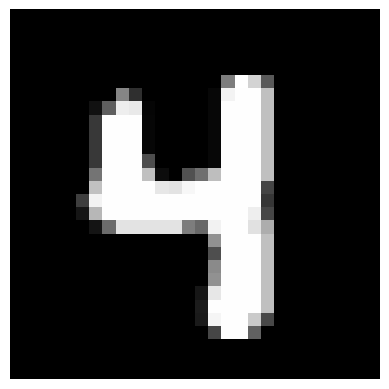

In [5]:
displaychar(train_data[58])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [6]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the Winery example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a parameter, and by setting it appropriately, we can improve the performance of the model. We will study **regularization** in greater detail over the coming weeks.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [7]:
# Use first 50000 for training
X_train = train_data[:50000]
y_train = train_labels[:50000]

# Use last 10000 for validation
X_val = train_data[50000:]
y_val = train_labels[50000:]

def fit_generative_model(x, y, c):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    identity_matrix = np.eye(d)
    
    for label in range(k):
        # Get all data points for the current label
        indices = (y == label)
        x_class = x[indices]
        
        # Calculate pi
        pi[label] = len(x_class) / len(x)
        
        # Calculate mu
        mu[label] = np.mean(x_class, axis=0)
        
        # Calculate sigma
        cov_matrix = np.cov(x_class, rowvar=False)
        
        # Regularization
        sigma[label] = cov_matrix + identity_matrix * c
        
    return mu, sigma, pi

# 3. Define a function to get predictions
# It uses log-probabilities to avoid underflow
def get_predictions(x_test, mu, sigma, pi):
    k = 10
    n = x_test.shape[0]
    scores = np.zeros((n, k))
    
    for label in range(k):
        # Calculate log(pi_j)
        log_pi = np.log(pi[label])
        
        # Calculate log P_j(x)
        # allow_singular=True is important as matrices can be close to singular
        try:
            log_prob_x = multivariate_normal.logpdf(x_test, 
                                                    mean=mu[label], 
                                                    cov=sigma[label], 
                                                    allow_singular=True)
        except np.linalg.LinAlgError as e:
            print(f"Error with label {label}: {e}")
            # If a matrix is truly singular, assign a very bad score
            log_prob_x = np.full(n, -np.inf)

        # Score is log(pi_j) + log P_j(x) [cite: 60]
        scores[:, label] = log_pi + log_prob_x
        
    # Pick the label with the highest log-probability [cite: 60]
    return np.argmax(scores, axis=1)



Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

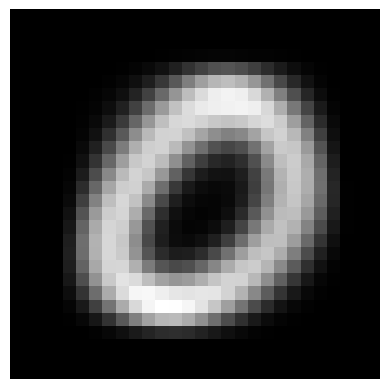

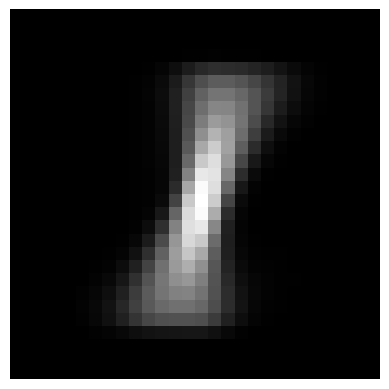

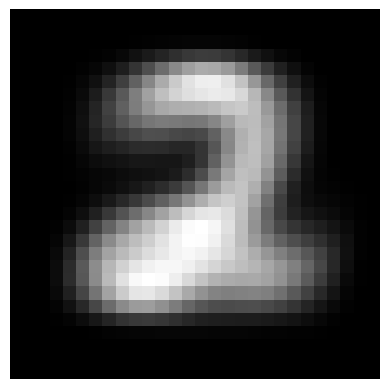

In [8]:
mu, sigma, pi = fit_generative_model(train_data, train_labels, 5000)
displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

## 3. Make predictions on test data

Now let's see how many errors your model makes on the test set.

In [9]:
# #
# # Compute log Pr(label|image) for each [test image,label] pair.
# #
# score = np.zeros((len(test_labels),k))
# for label in range(0,k):
#     rv = multivariate_normal(mean=mu[label], cov=sigma[label])
#     for i in range(0,len(test_labels)):
#        score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
# predictions = np.argmax(score, axis=1)
# #
# # Finally, tally up score
# #
# errors = np.sum(predictions != test_labels)
# print "Your model makes " + str(errors) + " errors out of 10000"

In [10]:
print("Starting validation loop to find best 'c'...")

c_values = [0.1, 1, 10, 100, 1000, 5000, 3300, 10000]
best_c = None
best_error = float('inf')

for c in c_values:
    print(f"--- Testing c = {c} ---")
    
    # Fit model on the 50k training set with the current c
    mu, sigma, pi = fit_generative_model(X_train, y_train, c)
    
    # Make predictions on the 10k validation set
    predictions = get_predictions(X_val, mu, sigma, pi)
    
    # Calculate error rate
    num_errors = np.sum(predictions != y_val)
    error_rate = num_errors / len(y_val)
    
    print(f"Validation Error: {error_rate*100:.2f}% ({num_errors} mistakes)")
    
    # Check if this is the best c so far 
    if error_rate < best_error:
        best_error = error_rate
        best_c = c
        
print(f"\nBest c = {best_c} (Error: {best_error*100:.2f}%)")

Starting validation loop to find best 'c'...
--- Testing c = 0.1 ---
Validation Error: 18.80% (1880 mistakes)
--- Testing c = 1 ---
Validation Error: 16.28% (1628 mistakes)
--- Testing c = 10 ---
Validation Error: 12.25% (1225 mistakes)
--- Testing c = 100 ---
Validation Error: 7.83% (783 mistakes)
--- Testing c = 1000 ---
Validation Error: 4.71% (471 mistakes)
--- Testing c = 5000 ---
Validation Error: 4.17% (417 mistakes)
--- Testing c = 3300 ---
Validation Error: 4.10% (410 mistakes)
--- Testing c = 10000 ---
Validation Error: 4.89% (489 mistakes)

Best c = 3300 (Error: 4.10%)


In [11]:
print(f"Training final model with best_c = {best_c}...")
# Fit the final model on the 50k training set [cite: 47]
mu_final, sigma_final, pi_final = fit_generative_model(X_train, y_train, best_c)

print("Evaluating on the TEST set...")
# Make predictions on the actual test set
test_predictions = get_predictions(test_data, mu_final, sigma_final, pi_final)

# Calculate test error
test_errors = np.sum(test_predictions != test_labels)
test_error_rate = test_errors / len(test_labels)

print(f"FINAL TEST ERROR: {test_error_rate*100:.2f}% ({test_errors} mistakes)")

Training final model with best_c = 3300...
Evaluating on the TEST set...
FINAL TEST ERROR: 4.32% (432 mistakes)


Displaying 5 random misclassified digits...
True Label: 4, Predicted Label: 9


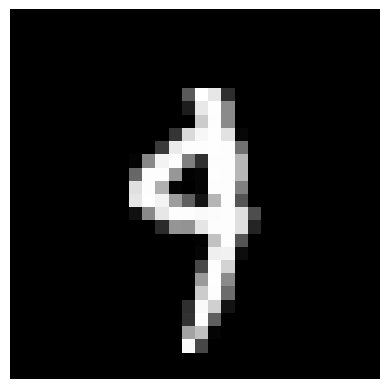

True Label: 7, Predicted Label: 9


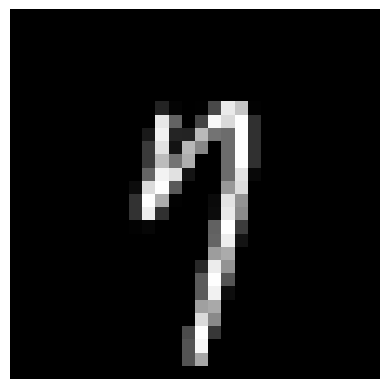

True Label: 8, Predicted Label: 1


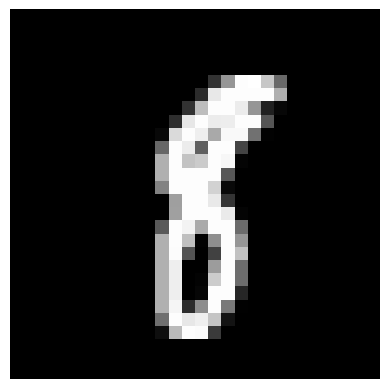

True Label: 4, Predicted Label: 6


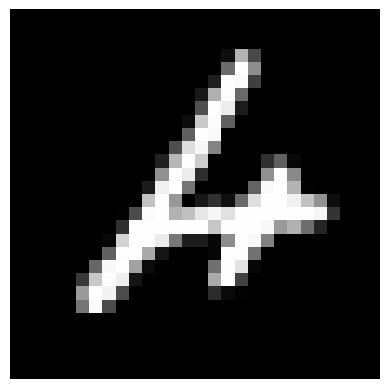

True Label: 7, Predicted Label: 9


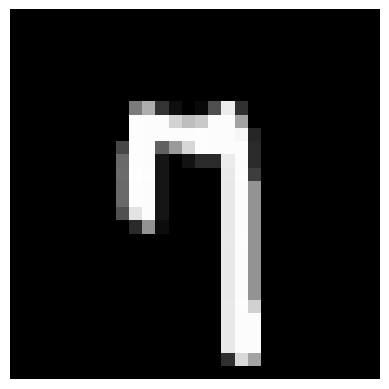

In [12]:
# Find the indices of all misclassified images
misclassified_indices = np.where(test_predictions != test_labels)[0]

# Pick 5 random indices from that list
random_choices = np.random.choice(misclassified_indices, 5, replace=False)

print("Displaying 5 random misclassified digits...")
# Loop and display
for i in random_choices:
    # Get the image, its true label, and its predicted label
    image = test_data[i]
    true_label = test_labels[i]
    predicted_label = test_predictions[i]
    
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    displaychar(image) # This function is from the notebook

## 4. Things to ponder

* What happens if you do not regularize the covariance matrices?
* What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?
* What value of c did you end up using? How many errors did your model make on the training set?
* We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?